# Machine Learning - Based Power Flow

This script shows how to interact with the class and apply the algorithm to new data. Please refer to README for more information. 

In [1]:
from forward_mlpf import ForwardMLPF
from inverse_mlpf import InverseMLPF
from make_pf_data import GenerateDataMLPF
import matplotlib.pyplot as plt
import numpy as np

# Data

Options: 
1. Load your own data to match the shapes of the following random variables for v, a, p, and q
2. Use make_pf_data.py to generate the data

Option 2 is demonstrated here. Note to start you need the file 'pecan_load_data' which can be generated following the Pecan Street querying instructions in the Solar Disaggregation module of this project. This should be a numpy matrix of shape (number of time stamps, number of homes), so each column represents the load profile of one home. The load profiles should be aligned so that each row represents the same time across all of the different homes. 

### Option 1: Load your own power flow data

In [2]:
## ~~ Replace this with loading your own data ~~ ##
# num_samples = 24*365
# num_bus = 14
# v = np.random.normal(loc=1.0, scale=0.025, size=(num_samples, num_bus))
# a = np.random.normal(loc=0.0, scale=0.01, size=(num_samples, num_bus))
# p = np.random.normal(loc=1.0, scale=1.0, size=(num_samples, num_bus))
# q = np.random.normal(loc=1.0, scale=1.0, size=(num_samples, num_bus))

# v = np.loadtxt('/Users/spowell2/Documents/VADER-Data/8bus/v.csv', delimiter=',') 
# a = np.loadtxt('/Users/spowell2/Documents/VADER-Data/8bus/a.csv', delimiter=',') 
# p = np.loadtxt('/Users/spowell2/Documents/VADER-Data/8bus/p.csv', delimiter=',')
# q = np.loadtxt('/Users/spowell2/Documents/VADER-Data/8bus/q.csv', delimiter=',') 
# print(np.shape(v))
# num_samples, num_bus = np.shape(v)

### Option 2: Create power flow data on a test network

Load home load profiles

In [3]:
# pecan_load_data = np.loadtxt('/Users/spowell2/Documents/pecan_home_data.csv',delimiter=',')

The you can use these home load profiles with a test network. To initialize the data generation class, pick which network you want to use from here: https://pandapower.readthedocs.io/en/v1.6.0/networks/synthetic_voltage_control_lv_networks.html OR https://pandapower.readthedocs.io/en/v1.6.0/networks/power_system_test_cases.html.

I recommend the first set for real residential networks, e.g. village_1.

Note: be careful of the other elements in the pandapower model, e.g. generation units, external grid connections, ... For some of the more complex test networks you may need to twek the run_pf method to change parameters or solve instructions for those cases. 

In [4]:
# load_gen_model = GenerateDataMLPF('rural_1')

Then feed the load data from Pecan Street into the object. This method assigns the homes to different buses in the network to try to match the load levels with which the test network shipped (matching how they would really be distributed).

In [5]:
# load_gen_model.prepare_loads(pecan_load_data)

In [6]:
# load_gen_model.evaluate_all_powerflows(display_counts=False)
# v = np.copy(load_gen_model.v_magnitude)
# a = np.copy(load_gen_model.v_angle)
# p = np.copy(load_gen_model.p_injection)
# q = np.copy(load_gen_model.q_injection)

In [7]:
# num_bus = np.copy(load_gen_model.num_buses)
# num_samples = np.copy(load_gen_model.num_times)

In [8]:
# np.save('/Users/spowell2/Documents/VADER-Data/rural1/v.npy', v)
# np.save('/Users/spowell2/Documents/VADER-Data/rural1/a.npy', a)
# np.save('/Users/spowell2/Documents/VADER-Data/rural1/p.npy', p)
# np.save('/Users/spowell2/Documents/VADER-Data/rural1/q.npy', q)
# np.save('/Users/spowell2/Documents/VADER-Data/rural1/num_bus.npy', num_bus)
# np.save('/Users/spowell2/Documents/VADER-Data/rural1/num_samples.npy', num_samples)

In [9]:
v = np.load('/Users/spowell2/Documents/VADER-Data/rural1/v.npy')
a = np.load('/Users/spowell2/Documents/VADER-Data/rural1/a.npy')
p = np.load('/Users/spowell2/Documents/VADER-Data/rural1/p.npy')
q = np.load('/Users/spowell2/Documents/VADER-Data/rural1/q.npy')
num_bus = np.load('/Users/spowell2/Documents/VADER-Data/rural1/num_bus.npy')
num_samples = np.load('/Users/spowell2/Documents/VADER-Data/rural1/num_samples.npy')

Below are plots of samples from the output. 

Values over time at Bus 3


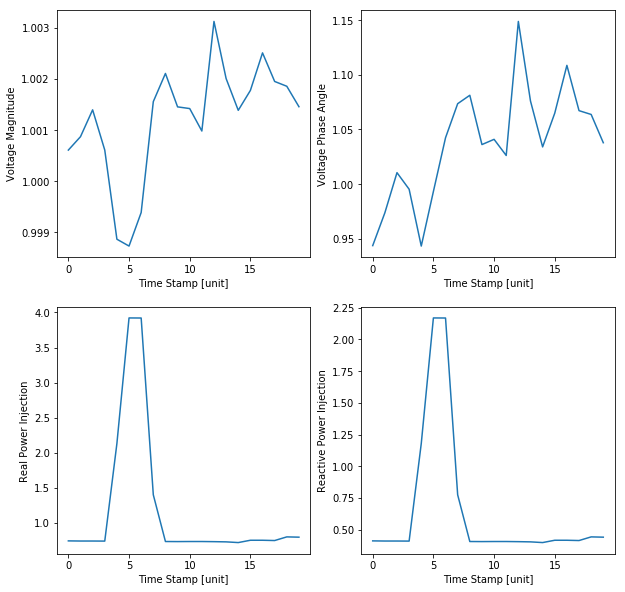

Values at time 0 over all buses


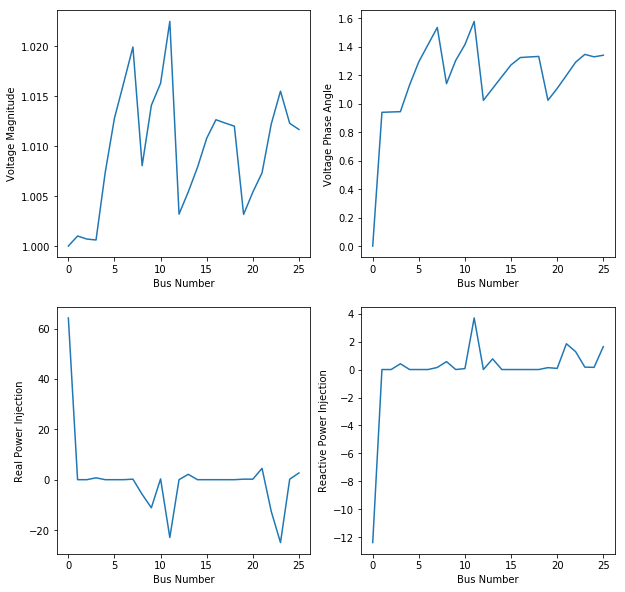

In [10]:
print('Values over time at Bus 3')
plt.figure(figsize=(10,10))
time_set = np.arange(0,20)
plt.subplot(221)
plt.plot(time_set,v[time_set,3])
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Voltage Magnitude')
plt.subplot(222)
plt.plot(time_set,a[time_set,3])
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Voltage Phase Angle')
plt.subplot(223)
plt.plot(time_set,p[time_set,3])
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Real Power Injection')
plt.subplot(224)
plt.plot(time_set,q[time_set,3])
plt.xlabel('Time Stamp [unit]')
plt.ylabel('Reactive Power Injection')
plt.show()

print('Values at time 0 over all buses')
plt.figure(figsize=(10,10))
bus_set = np.arange(0,num_bus)
plt.subplot(221)
plt.plot(bus_set,v[0,:])
plt.xlabel('Bus Number')
plt.ylabel('Voltage Magnitude')
plt.subplot(222)
plt.plot(bus_set,a[0,:])
plt.xlabel('Bus Number')
plt.ylabel('Voltage Phase Angle')
plt.subplot(223)
plt.plot(bus_set,p[0,:])
plt.xlabel('Bus Number')
plt.ylabel('Real Power Injection')
plt.subplot(224)
plt.plot(bus_set,q[0,:])
plt.xlabel('Bus Number')
plt.ylabel('Reactive Power Injection')
plt.show()


# Initialize Model

Now we start to build the ML model of the powerflow equations, using the data loaded or generated above. 

In [11]:
model = ForwardMLPF(num_bus, num_samples)

# Supply and Pre-Process Data

~ Add methods & lines to add noise and outliers ~

In [12]:
model.supply_full_data(p, q, v, a, num_bus, num_samples)

# Split the Data into Training and Testing

If rand_percent == True, then a **random** train_percent of the data is taken for the training set. 

If time_sers == True, then the **first** train_percent of the data is taken for the training set. 

The defaults for this method choose rand_percent with train_percent = 0.8.

In [13]:
model.train_test_split_data(rand_percent=True)

/Users/spowell2/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train the Model
Used with GridSearchCV, C_set and eps_set form the box of values for C and epsilon that the SVR model considers

Note: *fit_svr* might cause Convergence Warning errors and recommend scaling the data. The data is already being scaled with StandardScaler as it suggests. The Convergence Warning is caused by setting a low cap on the number of trianing iterations, max_iter. Setting max_iter higher will help this problem but will also make your training take longer; this is a trade-off. 

In [14]:
model.scale_data()

In [15]:
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [16]:
C_set = [5.0, 7.0, 10.0]  # Good values are often in the range of [0.5,10] 
eps_set = [1e-5, 1e-3, 0.1]  # Good values are often in the range of [1e-7, 1e-1]
max_iter = 1e4  # Good values are usually in the range of 1e4, 1e5

In [ ]:
model.fit_svr(C_set, eps_set, max_iter)

In [ ]:
print('The best Cs were ', np.transpose(model.C_best), 'and the best epsilons were ', 
      np.transpose(model.eps_best))

# Plot of the Support Vectors required in each model
plt.figure()
plt.plot(np.arange(0, 2*model.num_bus), model.num_SV)
plt.xlabel('Bus Number')
plt.ylabel('Number of SVs Required')
plt.show()

# Test the Model

Apply the model to the training set and return predictions, test error. 

In [ ]:
model.test_error_svr()

In [ ]:
print('The total scaled RMSE was: ', model.scaled_total_rmse)
print('The mean real RMSE was: ', model.mean_rmse)

In [ ]:
sample_timestamp = 10  # Select a timestamp in the test set to investigate
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(0, model.num_bus), 
         scale_back_multiple_y(model.y_test[sample_timestamp, np.arange(0, model.num_bus)], np.arange(0, model.num_bus)), 
         np.arange(0, model.num_bus), 
         scale_back_multiple_y(model.test_y_values[sample_timestamp, np.arange(0, model.num_bus)], np.arange(0, model.num_bus)))
plt.xlabel('Bus Number')
plt.ylabel('Real Power Injection')
plt.legend(labels=['True', 'Estimate'])
plt.subplot(122)
plt.plot(np.arange(0, model.num_bus), 
         scale_back_multiple_y(model.y_test[sample_timestamp, np.arange(model.num_bus, 2*model.num_bus)], np.arange(model.num_bus, 2*model.num_bus)), 
         np.arange(0, model.num_bus), 
         scale_back_multiple_y(model.test_y_values[sample_timestamp,np.arange(model.num_bus, 2*model.num_bus)], np.arange(model.num_bus, 2*model.num_bus)))
plt.xlabel('Bus Number')
plt.ylabel('Reactive Power Injection')
plt.legend(labels=['True', 'Estimate'])
plt.show()
print('Sample Error '+str(model.test_error_values[sample_timestamp][0]))
